In [1]:
import networkx as nx
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
import random
import time
#%matplotlib notebook

In [2]:
def resetDeadAgent(g, current):
    g.nodes[current]['fear']  = 0
    g.nodes[current]['reinforcement'] = 0
    g.nodes[current]['happiness'] = 0
    g.nodes[current]['anger'] = 0
    g.nodes[current]['sadness'] = 0
    g.nodes[current]['surprise']  = 0
    g.nodes[current]['disgust']  = 0

def updateSurprise(g, previous, current):
    # surprise is only updated at the beginning of each match
    g.nodes[current]['surprise']  = 2 * (previous.nodes[current]['vi'] \
                                     - previous.nodes[current]['vt']) / previous.nodes[current]['vi'] - 1

def updateNeighborReinforcement(previous, adj, current):
    neighbor_reinforcement = 0
    if previous.nodes[current]['status'] == 'coop':
        if previous.nodes[adj]['status'] == 'def':
            neighbor_reinforcement = previous.nodes[current]['rewards']['CD']
        if previous.nodes[adj]['status'] == 'coop':
            neighbor_reinforcement = previous.nodes[current]['rewards']['CC']
    elif previous.nodes[current]['status'] == 'def': 
        if previous.nodes[adj]['status'] == 'def':
            neighbor_reinforcement = previous.nodes[current]['rewards']['DD']
        if previous.nodes[adj]['status'] == 'coop':
            neighbor_reinforcement = previous.nodes[current]['rewards']['DC']
    else: # neighbor is dead
        neighbor_reinforcement = 0
    return neighbor_reinforcement

def updateFear(g, neighbor_reinforcement, current):
    if neighbor_reinforcement: # positive reinforcement 
        g.nodes[current]['fear'] -= 2 / g.nodes[current]['vi']
    
def interact(g, matchID):
    previous = copy.deepcopy(g)
    for current in g.nodes:
        if previous.nodes[current]['status'] == 'dead':
            resetDeadAgent(g, current)
        else: # agent is still alive
            # initialize parameters before interaction
            g.nodes[current]['reinforcement']  = 0
            g.nodes[current]['fear'] = 1
            happiness_curr = 0 # for happiness
            anger_curr = 1 # for anger
            sadness_curr = 0 # for sadness 
            updateSurprise(g, previous, current)
            # interaction with neighbors
            for adj in list(g.adj[current]): 
                # update reinforcement value
                neighbor_reinforcement = updateNeighborReinforcement(previous, adj, current)
                g.nodes[current]['historyRe'].loc[adj, matchID] = neighbor_reinforcement
                g.nodes[current]['reinforcement']  += neighbor_reinforcement
                updateFear(g, neighbor_reinforcement, current)
                # update happiness (happiness_curr) value
                if neighbor_reinforcement: # positive reinforcement 
                    happiness_curr += 1
                else: # zero reinforcement 
                    happiness_curr -= 1
                # update anger (anger_curr) value
                if neighbor_reinforcement > r_exp:
                    anger_curr -= 2 / g.nodes[current]['vi']
                # update sadness (sadness_curr) value
                if neighbor_reinforcement: # positive reinforcement 
                    sadness_curr -= 1 / g.nodes[current]['vi'] 
                else:
                    sadness_curr += 1 / g.nodes[current]['vi'] 
            # update happiness value (adding weight and happiness_prev)
            g.nodes[current]['happiness'] = (1 - a_happiness) * happiness_curr / 4 + \
                a_happiness * previous.nodes[current]['happiness'] 
            # update anger value (adding weight and anger_marker)
            if previous.nodes[current]['anger'] > 0:
                anger_marker = 1
            else:
                anger_marker = 0
            g.nodes[current]['anger'] = (1 - a_anger) * anger_curr + \
                a_anger * anger_marker
            # update sadness value (adding weight and sadness_marker)
            if previous.nodes[current]['sadness'] > 0:
                sadness_marker = 1
            else:
                sadness_marker = 0
            g.nodes[current]['sadness'] = (1 - a_sadness) * sadness_curr + \
                a_sadness * sadness_marker
            # update  disgust  value
            if previous.nodes[current]['disgust'] > 0:
                disgust_marker = 1
            else:
                disgust_marker = -1
            g.nodes[current]['disgust'] = (1 - a_disgust) * g.nodes[current]['surprise'] + \
                a_disgust * disgust_marker
    # Record properties into DF
    reTable.loc[:, matchID] = [g.nodes[n]['reinforcement'] for n in g.nodes]
    fearTable.loc[:, matchID] = [g.nodes[n]['fear'] for n in g.nodes]
    happinessTable.loc[:, matchID] = [g.nodes[n]['happiness'] for n in g.nodes]
    angerTable.loc[:, matchID] = [g.nodes[n]['anger'] for n in g.nodes]
    sadnessTable.loc[:, matchID] = [g.nodes[n]['sadness'] for n in g.nodes]
    surpriseTable.loc[:, matchID] = [g.nodes[n]['surprise'] for n in g.nodes]
    disgustTable.loc[:, matchID] = [g.nodes[n]['disgust'] for n in g.nodes]
    
    
def statusUpdate(g, matchID):
    # 2. Update status for each agent 
    #     2.1 Determine if agent is dead
    #     2.2 Cooperating agent turns into defecting agents
    #     2.3 Update max possible reinforcement possible for each agent
    # deep copy the previous graph because we do not want the sequence of agent affect the 
    #     result after each match
    previous = copy.deepcopy(g)
    # check if any agent's reinforcement is bellow ti threshold, which lead to a death
    # if neighbor's reinforcement is higher, there is a probability (prChange) of changing the status
    for current in previous.nodes:
        if previous.nodes[current]['reinforcement'] < ti: # agent will die
            g.nodes[current]['status'] = 'dead'
            continue
        if previous.nodes[current]['status'] == 'coop': # coop agents are susceptible to becoming defectors
            hasDefNeighbor = 0
            for adj in list(previous.adj[current]):
                if previous.nodes[adj]['status'] == 'def':
                    hasDefNeighbor = 1
            if hasDefNeighbor:
                # there is at least a defecting neighbor   
                rand = random.random()
                if (rand < prChange): # probability of changing from coop to def
                    g.nodes[current]['status'] = 'def'
    statusTable.loc[:, matchID + 1] = [g.nodes[n]['status'] for n in g.nodes]
    # we now update the max possible reinforcement for the agent when assuming there are only 
    #     cooporators and dead agents. We also update the current number of alive neighbors
    for current in g.nodes:
        maxRe = 0
        vt = 0
        for adj in list(g.adj[current]):
            if g.nodes[adj]['status'] != 'dead':
                # assuming all cooporators to get max reinforcement possible
                maxRe += g.nodes[current]['rewards']['CC']
                vt += 1
        g.nodes[current]['maxRe'] = maxRe
        g.nodes[current]['vt'] = vt
    maxReTable.loc[:, matchID]  = [g.nodes[n]['maxRe'] for n in g.nodes]

In [3]:
def plotGrid_static(g, matchID):
    # function plot the grid for the network
    # color code: red -> defector, blue -> cooporator, black -> dead
    # param: g a networkx graph
    pos = dict((n, n) for n in g)
    labels = dict( ((i, j), i + (length-1-j) * 10 ) for i, j in g.nodes() )
    # get the list of nodes in each status
    coopList = [n for n in g.nodes if g.nodes[n]['status'] == 'coop']
    defList = [n for n in g.nodes if g.nodes[n]['status'] == 'def']
    deadList = [n for n in g.nodes if g.nodes[n]['status'] == 'dead']
    # draw nodes and edges 
    plt.figure(figsize = (5, 5))
    options = {"node_size": 10, "alpha": 0.8}
    nx.draw_networkx_nodes(g, pos, nodelist=coopList, label = 'Cooporator',
                           node_color="b", **options)
    nx.draw_networkx_nodes(g, pos, nodelist=defList, label = 'Defector',
                           node_color="r", **options)
    nx.draw_networkx_nodes(g, pos, nodelist=deadList, label = 'Dead Agent',
                           node_color="k", **options)
    nx.draw_networkx_edges(g, pos, width=1.0, alpha=0.5)
    plt.legend(loc = 4)
    plt.title('Match ' + str(matchID))

In [4]:
def match(g, matchID):
    # 1. Interact to upda reinforcement value for each agent to interact with its neighbors
    interact(g, matchID)
    # 2. Update status for each agent 
    #     2.1 Determine if agent is dead
    #     2.2 Cooperating agent turns into defecting agents
    #     2.3 Update max possible reinforcement possible for each agent
    statusUpdate(g, matchID)


In [5]:
def resetNetwork():
    # agents have properties: 
    #     - Basic Properties: 'status', 'vi', 'vt', 'rewards', 'reinforcement', 'maxRe', 'historyRe'
    #     - Emotion Properties: 'fear', 'happiness'

    # Basic Property 1: 'status'
    # there are three possible values for states attribute for a node: coop, def, or dead
    for node in g.nodes:
        g.nodes[node]['status'] = 'coop'
    # stattable traces the status of each node at each match 
    g.nodes[(length // 2, length // 2)]['status'] = 'def' # set the first defector
    statusTable.loc[:, 1] =   [g.nodes[n]['status'] for n in g.nodes] 

    # Basic Property 2: 'vi'
    # 'vi' attribute is the number of neighbors for each node at the beginning 
    #     of the simulation 

    # Basic Property 3: 'vt'
    # 'vt' attribute is the number of neighbors for each node at the match t 
    for node in g.nodes:
        g.nodes[node]['vt'] = len(list(g.adj[node]))

    # Basic Property 4: 'rewards'
    # The rewards attribute stores the rewards of the node at different situations 
    #     within one interaction (CD, DC, DD, CC)

    # Basic Property 5: 'reinforcement'
    # The reinforcement attribute stores the reinforcement received during each match 
    for node in g.nodes:
        g.nodes[node]['reinforcement'] = 1
    # retable traces the reinforcement received by each node at each match 
    reTable.loc[:, 0] = [g.nodes[n]['reinforcement'] for n in g.nodes]

    # Basic Property 6: 'maxRe'
    # maxRe stores the max possible reinforcement for a node at each match 
    for node in g.nodes:
        g.nodes[node]['maxRe'] = 1
    # maxReTable traces the max possible reinforcement an agent could get if all 
    #     alive agents are cooporators 
    maxReTable.loc[:, 0] = [g.nodes[n]['maxRe'] for n in g.nodes]

    # Basic Property 7: 'historyRe'
    # This is the table storing reinforcement received when interacting with neighbors 
    for node in g.nodes:
        g.nodes[node]['historyRe'] = pd.DataFrame(index = list(dict(g.adj[node]).keys()))
        g.nodes[node]['historyRe'][0] = [0] * len(list(dict(g.adj[node]).keys()))

In [6]:
def resetEmotion():
    # Emotion Property 1: 'fear' 
    # update rule: fear = 1 at the beginning of each match
    #     for each interaction: fear -= r * 2 - vi (where r is reinforcement from interaction)
    for node in g.nodes:
        g.nodes[node]['fear'] = -1
    fearTable.loc[:, 0] = [g.nodes[n]['fear'] for n in g.nodes]

    # Emotion Property 2: 'happiness' ??? Modified to fit only positive reinforcement 
    # update rule: happiness = a_happiness * happiness_prev / 4 + (1 - a_happiness) * happiness_curr
    #     a_happiness is a parameter
    #     happiness_prev is happiness value from previous match 
    #     happiness_curr is 0 at the beginning of each match 
    #         for each interaction: if r == 0 -> happiness_curr -= 1, else (r > 0) -> happiness_curr += 1
    for node in g.nodes:
        g.nodes[node]['happiness'] = 0
    happinessTable.loc[:, 0] = [g.nodes[n]['happiness'] for n in g.nodes]

    # Emotion Property 3: 'anger' 
    # update rule: anger = a_anger * anger_marker + (1 - a_anger) * anger_curr
    #     a_anger is a parameter
    #     anger_marker is anger value from previous match 
    #     anger_curr is 1 at the beginning of each match 
    #         for each interaction: if r >= r_exp -> anger_curr -= 2 / vi
    #     r_exp is a pre defined parameter of expected reinforcement
    for node in g.nodes:
        g.nodes[node]['anger'] = 1
    angerTable.loc[:, 0] = [g.nodes[n]['anger'] for n in g.nodes]

    # Emotion Property 4: 'sadness' 
    # update rule: sadness = a_sadness * sadness_marker + (1 - a_sadness) * sadness_curr
    #     a_sadness is a parameter
    #     sadness_marker is a value determined by the anger value from the previous match 
    #     sadness_curr is 0 at the beginning of each match 
    #         for each interaction: if r == 0 -> sadness_curr -= 2 / vi
    #             else: sadness_curr += 2 / vi
    for node in g.nodes:
        g.nodes[node]['sadness'] = 0
    sadnessTable.loc[:, 0] = [g.nodes[n]['anger'] for n in g.nodes]

    # Emotion Property 5: 'surprise' 
    # update rule: surprise is only updated at beginning of each match 
    #     surprise = 2 * (vi - vt-1) / vi - 1
    for node in g.nodes:
        g.nodes[node]['surprise'] = -1
    surpriseTable.loc[:, 0] = [g.nodes[n]['surprise'] for n in g.nodes]

    # Emotion Property 6: 'disgust' 
    # update rule: disgust = a_disgust * disgust_marker + (1 - a_disgust) * surprise
    #     a_disgust is a parameter
    #     disgust_marker is a value determined by the anger value from the previous match 
    for node in g.nodes:
        g.nodes[node]['disgust'] = -1
    disgustTable.loc[:, 0] = [g.nodes[n]['disgust'] for n in g.nodes]

In [7]:
# ti is the threshold for the reinforcement received by the node to survive
ti = 0.5 # meaning that at least one of the neighbors are cooporator 
# prChange is the probability of changing status (def & coop) when neighbor 
#     has higher reinforcement
prChange = 0.25

length = 15 # number of nodes in the horizontal axis
width = 15 # number of nodes in the vertical axis
n_agent = length * width
g = nx.grid_2d_graph(length,width)

# Basic Property 1: 'status'
# there are three possible values for states attribute for a node: coop, def, or dead
# stattable traces the status of each node at each match 
statusTable = pd.DataFrame(index = list(g.nodes))

# Basic Property 2: 'vi'
# 'vi' attribute is the number of neighbors for each node at the beginning 
#     of the simulation 
for node in g.nodes:
    g.nodes[node]['vi'] = len(list(g.adj[node]))

# Basic Property 3: 'vt'
# 'vt' attribute is the number of neighbors for each node at the match t 

# Basic Property 4: 'rewards'
# The rewards attribute stores the rewards of the node at different situations 
#     within one interaction (CD, DC, DD, CC)
for node in g.nodes:
    g.nodes[node]['rewards'] = {'DD' : 0,
                               'CD' : 0,
                               'CC' : 1 / g.nodes[node]['vi'],
                               'DC' : 2 / g.nodes[node]['vi']}

# Basic Property 5: 'reinforcement'
# The reinforcement attribute stores the reinforcement received during each match 
# retable traces the reinforcement received by each node at each match 
reTable = pd.DataFrame(index = list(g.nodes))

# Basic Property 6: 'maxRe'
# maxRe stores the max possible reinforcement for a node at each match 
# maxReTable traces the max possible reinforcement an agent could get if all 
#     alive agents are cooporators 
maxReTable = pd.DataFrame(index = list(g.nodes))

# Basic Property 7: 'historyRe'
# This is the table storing reinforcement received when interacting with neighbors 

In [8]:
# Emotion Property 1: 'fear' 
# update rule: fear = 1 at the beginning of each match
#     for each interaction: fear -= r * 2 - vi (where r is reinforcement from interaction)
fearTable = pd.DataFrame(index = list(g.nodes))

# Emotion Property 2: 'happiness' ??? Modified to fit only positive reinforcement 
# update rule: happiness = a_happiness * happiness_prev / 4 + (1 - a_happiness) * happiness_curr
#     a_happiness is a parameter
#     happiness_prev is happiness value from previous match 
#     happiness_curr is 0 at the beginning of each match 
#         for each interaction: if r == 0 -> happiness_curr -= 1, else (r > 0) -> happiness_curr += 1
happinessTable = pd.DataFrame(index = list(g.nodes))
a_happiness = 0.2

# Emotion Property 3: 'anger' 
# update rule: anger = a_anger * anger_marker + (1 - a_anger) * anger_curr
#     a_anger is a parameter
#     anger_marker is anger value from previous match 
#     anger_curr is 1 at the beginning of each match 
#         for each interaction: if r >= r_exp -> anger_curr -= 2 / vi
#     r_exp is a pre defined parameter of expected reinforcement
angerTable = pd.DataFrame(index = list(g.nodes))
a_anger = 0.2 
r_exp = 0.1


# Emotion Property 4: 'sadness' 
# update rule: sadness = a_sadness * sadness_marker + (1 - a_sadness) * sadness_curr
#     a_sadness is a parameter
#     sadness_marker is a value determined by the anger value from the previous match 
#     sadness_curr is 0 at the beginning of each match 
#         for each interaction: if r == 0 -> sadness_curr -= 2 / vi
#             else: sadness_curr += 2 / vi
sadnessTable = pd.DataFrame(index = list(g.nodes))
a_sadness = 0.2

# Emotion Property 5: 'surprise' 
# update rule: surprise is only updated at beginning of each match 
#     surprise = 2 * (vi - vt-1) / vi - 1
surpriseTable = pd.DataFrame(index = list(g.nodes))

# Emotion Property 6: 'disgust' 
# update rule: disgust = a_disgust * disgust_marker + (1 - a_disgust) * surprise
#     a_disgust is a parameter
#     disgust_marker is a value determined by the anger value from the previous match 
disgustTable = pd.DataFrame(index = list(g.nodes))
a_disgust = 0.2

<ipython-input-3-bdd6db81a20b>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = (5, 5))


0 Simulation, 2 Match Done!
0 Simulation, 3 Match Done!
0 Simulation, 4 Match Done!
0 Simulation, 5 Match Done!
0 Simulation, 6 Match Done!
0 Simulation, 7 Match Done!
0 Simulation, 8 Match Done!
0 Simulation, 9 Match Done!
0 Simulation, 10 Match Done!
0 Simulation, 11 Match Done!
0 Simulation, 12 Match Done!
0 Simulation, 13 Match Done!
0 Simulation, 14 Match Done!
0 Simulation, 15 Match Done!
0 Simulation, 16 Match Done!
0 Simulation, 17 Match Done!
0 Simulation, 18 Match Done!
0 Simulation, 19 Match Done!
0 Simulation, 20 Match Done!
0 Simulation, 21 Match Done!
0 Simulation, 22 Match Done!
0 Simulation, 23 Match Done!
0 Simulation, 24 Match Done!
0 Simulation, 25 Match Done!
0 Simulation, 26 Match Done!
0 Simulation, 27 Match Done!
0 Simulation, 28 Match Done!
0 Simulation, 29 Match Done!
0 Simulation, 30 Match Done!
0 Simulation, 31 Match Done!
0 Simulation, 32 Match Done!
0 Simulation, 33 Match Done!
0 Simulation, 34 Match Done!
0 Simulation, 35 Match Done!
0 Simulation, 36 Match

7 Simulation, 14 Match Done!
7 Simulation, 15 Match Done!
7 Simulation, 16 Match Done!
7 Simulation, 17 Match Done!
7 Simulation, 18 Match Done!
7 Simulation, 19 Match Done!
7 Simulation, 20 Match Done!
7 Simulation, 21 Match Done!
7 Simulation, 22 Match Done!
7 Simulation, 23 Match Done!
7 Simulation, 24 Match Done!
7 Simulation, 25 Match Done!
7 Simulation, 26 Match Done!
7 Simulation, 27 Match Done!
7 Simulation, 28 Match Done!
7 Simulation, 29 Match Done!
7 Simulation, 30 Match Done!
7 Simulation, 31 Match Done!
7 Simulation, 32 Match Done!
7 Simulation, 33 Match Done!
7 Simulation, 34 Match Done!
7 Simulation, 35 Match Done!
7 Simulation, 36 Match Done!
7 Simulation, 37 Match Done!
7 Simulation, 38 Match Done!
7 Simulation, 39 Match Done!
7 Simulation, 40 Match Done!
8 Simulation, 2 Match Done!
8 Simulation, 3 Match Done!
8 Simulation, 4 Match Done!
8 Simulation, 5 Match Done!
8 Simulation, 6 Match Done!
8 Simulation, 7 Match Done!
8 Simulation, 8 Match Done!
8 Simulation, 9 Match

14 Simulation, 22 Match Done!
14 Simulation, 23 Match Done!
14 Simulation, 24 Match Done!
14 Simulation, 25 Match Done!
14 Simulation, 26 Match Done!
14 Simulation, 27 Match Done!
14 Simulation, 28 Match Done!
14 Simulation, 29 Match Done!
14 Simulation, 30 Match Done!
14 Simulation, 31 Match Done!
14 Simulation, 32 Match Done!
14 Simulation, 33 Match Done!
14 Simulation, 34 Match Done!
14 Simulation, 35 Match Done!
14 Simulation, 36 Match Done!
14 Simulation, 37 Match Done!
14 Simulation, 38 Match Done!
14 Simulation, 39 Match Done!
14 Simulation, 40 Match Done!
15 Simulation, 2 Match Done!
15 Simulation, 3 Match Done!
15 Simulation, 4 Match Done!
15 Simulation, 5 Match Done!
15 Simulation, 6 Match Done!
15 Simulation, 7 Match Done!
15 Simulation, 8 Match Done!
15 Simulation, 9 Match Done!
15 Simulation, 10 Match Done!
15 Simulation, 11 Match Done!
15 Simulation, 12 Match Done!
15 Simulation, 13 Match Done!
15 Simulation, 14 Match Done!
15 Simulation, 15 Match Done!
15 Simulation, 16 

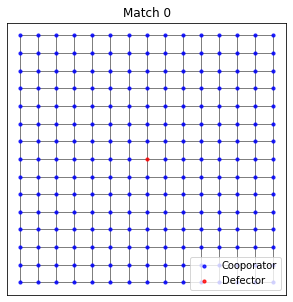

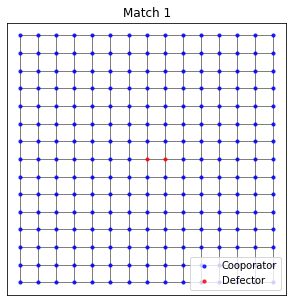

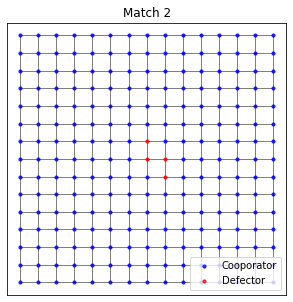

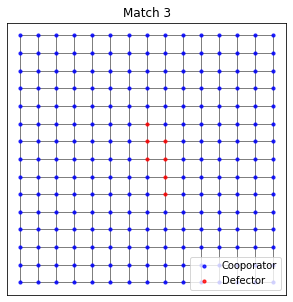

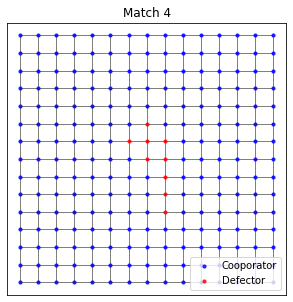

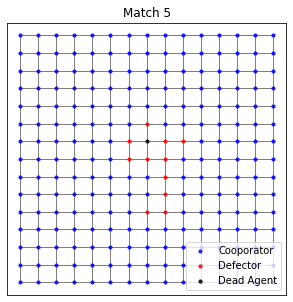

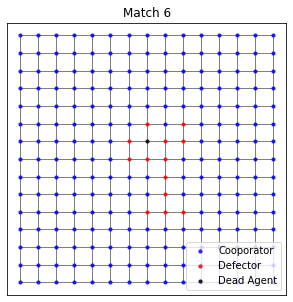

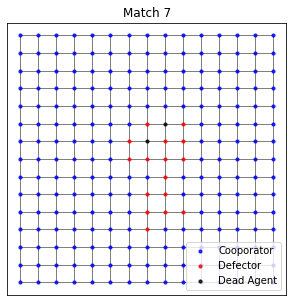

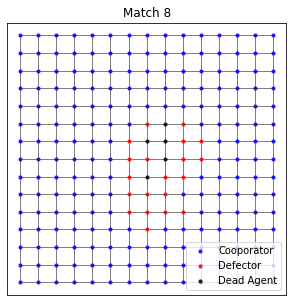

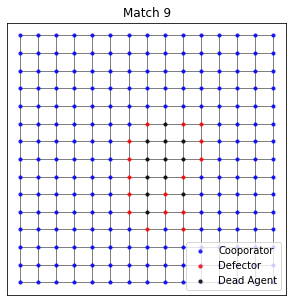

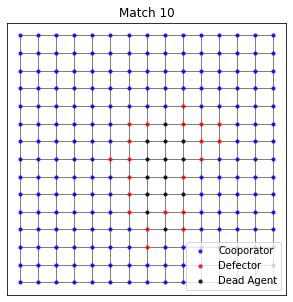

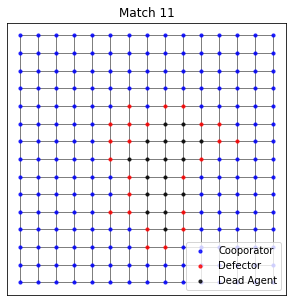

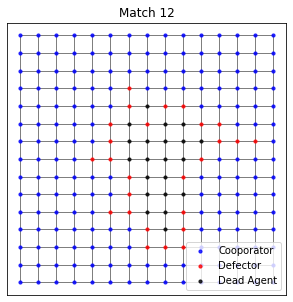

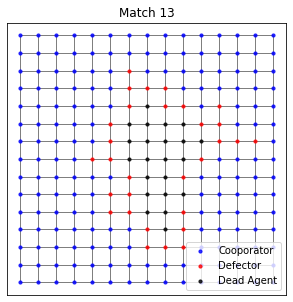

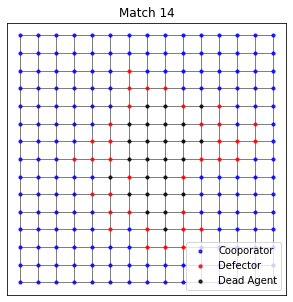

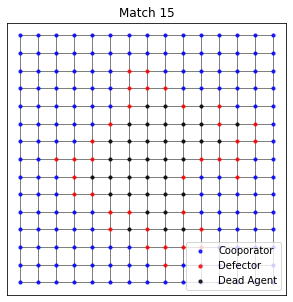

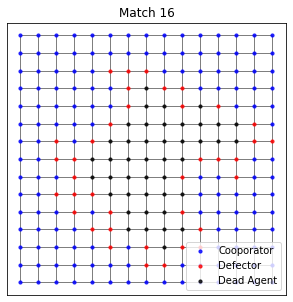

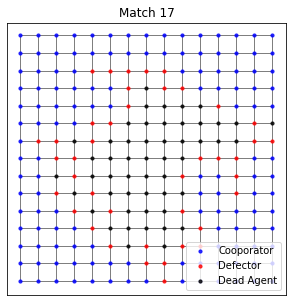

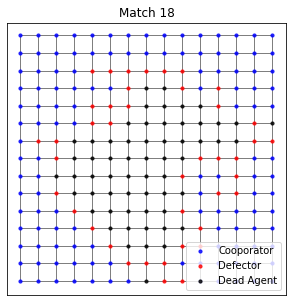

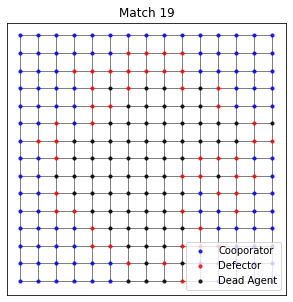

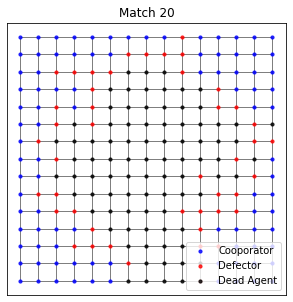

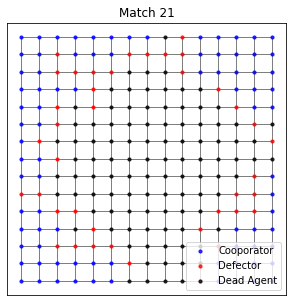

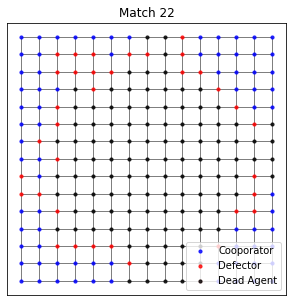

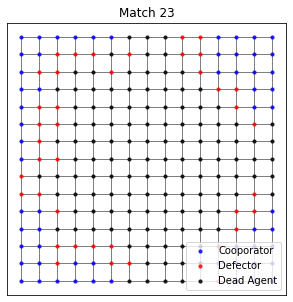

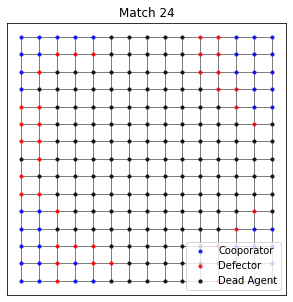

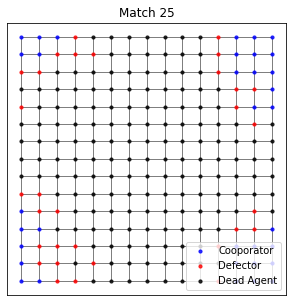

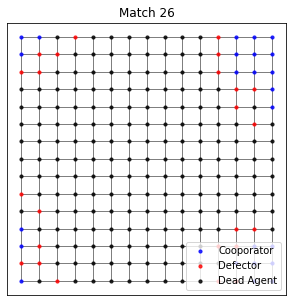

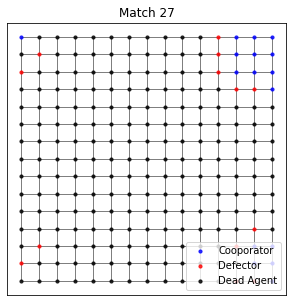

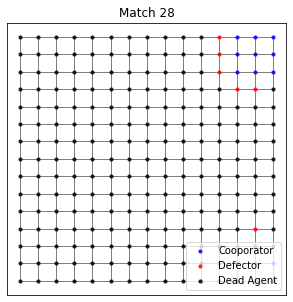

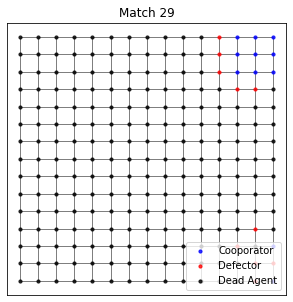

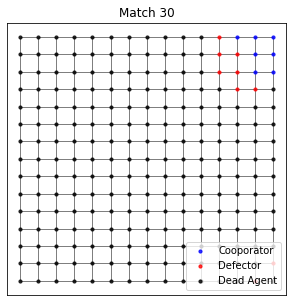

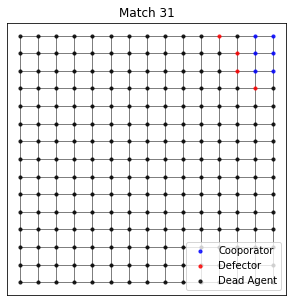

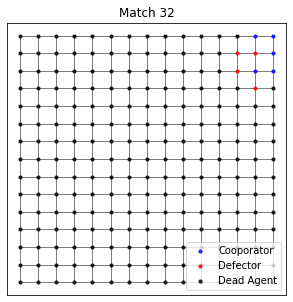

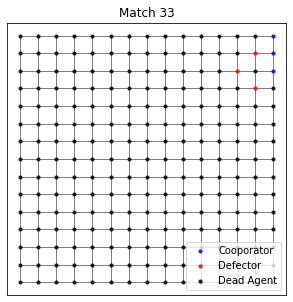

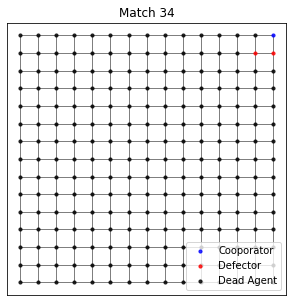

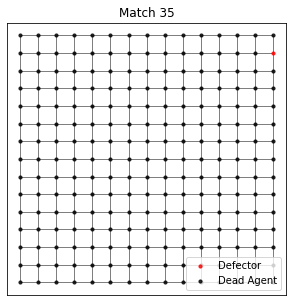

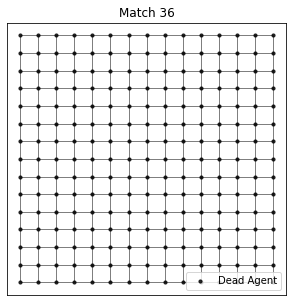

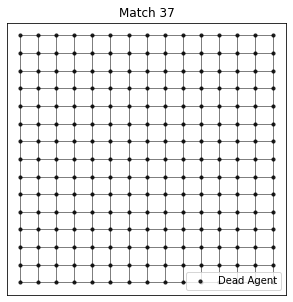

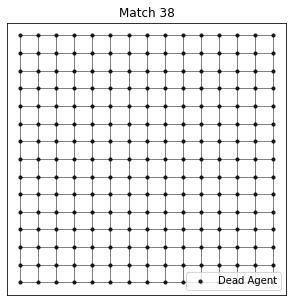

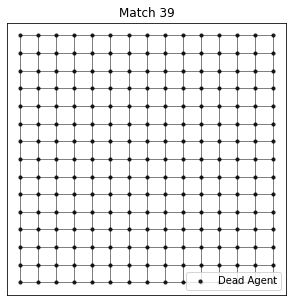

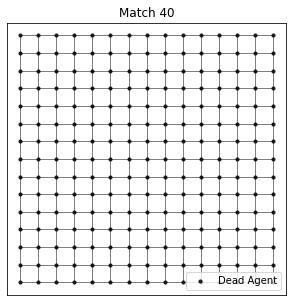

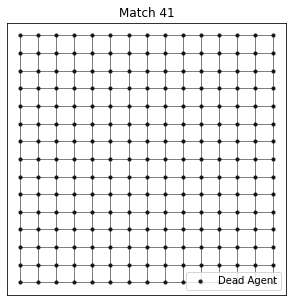

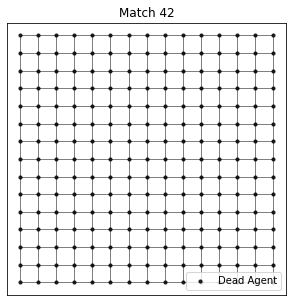

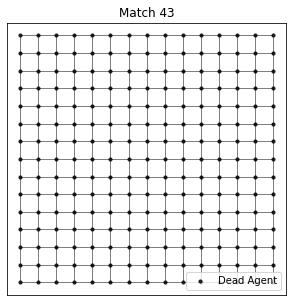

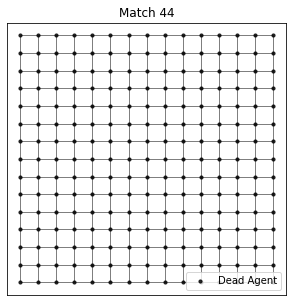

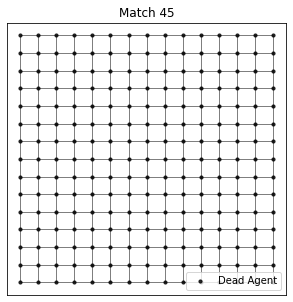

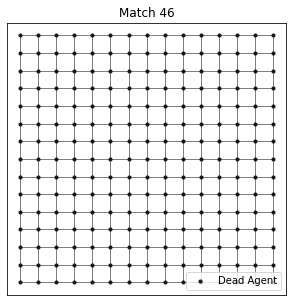

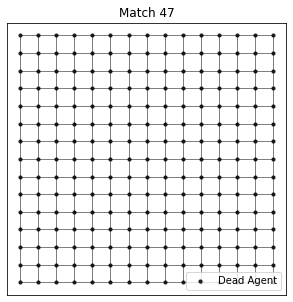

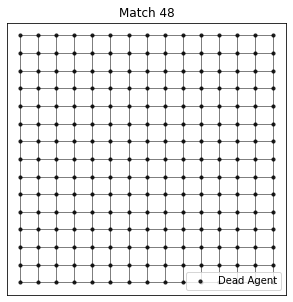

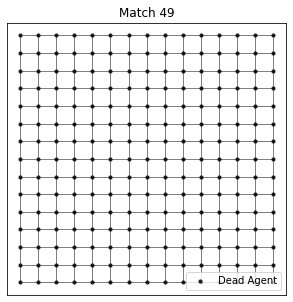

In [9]:
resetNetwork()
resetEmotion()
matchID = 0
for i in range(50):
    plotGrid_static(g, matchID)
    matchID += 1
    match(g, matchID)
    
reTable_prev = reTable.copy()
maxReTable_prev = maxReTable.copy()
fearTable_prev = fearTable.copy()
happinessTable_prev = happinessTable.copy()
angerTable_prev = angerTable.copy()
sadnessTable_prev = sadnessTable.copy()
surpriseTable_prev = surpriseTable.copy()
disgustTable_prev = disgustTable.copy()

for simID in range(20): # 10 simulations
    resetNetwork()
    resetEmotion()
    for matchID in range(1, 40): # 50 mathces
        # plotGrid_static(g, matchID)
        matchID += 1
        match(g, matchID)
        print(f'{simID} Simulation, {matchID} Match Done!')
    
    # taking the average of properties for each simulation
    reArr = (reTable_prev.values + reTable.values) / 2
    reTable_prev = pd.DataFrame(data = reArr, index = reTable.index, columns = reTable.columns)
    maxReArr = (maxReTable_prev.values + maxReTable.values) / 2
    maxReTable_prev = pd.DataFrame(data = maxReArr, index = maxReTable.index, columns = maxReTable.columns)
    fearArr = (fearTable_prev.values + fearTable.values) / 2
    fearTable_prev = pd.DataFrame(data = fearArr, index = fearTable.index, columns = fearTable.columns)
    happinessArr = (happinessTable_prev.values + happinessTable.values) / 2
    happinessTable_prev = pd.DataFrame(data = happinessArr, index = happinessTable.index, columns = happinessTable.columns)
    angerArr = (angerTable_prev.values + angerTable.values) / 2
    angerTable_prev = pd.DataFrame(data = angerArr, index = angerTable.index, columns = angerTable.columns)
    sadnessArr = (sadnessTable_prev.values + sadnessTable.values) / 2
    sadnessTable_prev = pd.DataFrame(data = sadnessArr, index = sadnessTable.index, columns = sadnessTable.columns)
    surpriseArr = (surpriseTable_prev.values + surpriseTable.values) / 2
    surpriseTable_prev = pd.DataFrame(data = surpriseArr, index = surpriseTable.index, columns = surpriseTable.columns)
    disgustArr = (disgustTable_prev.values + disgustTable.values) / 2
    disgustTable_prev = pd.DataFrame(data = disgustArr, index = disgustTable.index, columns = disgustTable.columns)



In [21]:
def reIndex(target):
    return target.loc[:, range(1, matchID + 1)]
statusTable = reIndex(statusTable)
reTable = reIndex(reTable_prev)
maxReTable = reIndex(maxReTable_prev)
fearTable = reIndex(fearTable_prev)
happinessTable = reIndex(happinessTable_prev)
angerTable = reIndex(angerTable_prev)
sadnessTable  = reIndex(sadnessTable_prev)
surpriseTable = reIndex(surpriseTable_prev)
disgustTable = reIndex(disgustTable_prev)
#  = reIndex()

In [37]:
def tallyState(state, statusTable):
    li = []
    for col in statusTable.columns:
        if state not in list(statusTable.loc[:, col]):
            li.append(0)
        else:
            li.append(statusTable.loc[:, col].value_counts()[state])
    return np.array(li)

tallyCoop = tallyState('coop', statusTable)
tallyDef = tallyState('def', statusTable)
tallyDead = tallyState('dead', statusTable)
tallyAlive = [n_agent] + list(tallyCoop + tallyDef)
tallyAlive = tallyAlive[:-1]

def tallyProperty(statusTable, propertyTable):
    # for some property table, find the sum of the property at each match for cooporators and defectors
    cooperators, defectors = [], []
    for col in statusTable.columns:
        if 'coop' in set(statusTable.loc[:, col]):
            cooperators.append(propertyTable.loc[:, col][statusTable.loc[: , col] == 'coop'].sum())
        else:
            cooperators.append(0)
        if 'def' in set(statusTable.loc[:, col]):
            defectors.append(propertyTable.loc[:, col][statusTable.loc[: , col] == 'def'].sum())
        else:
            defectors.append(0)
    return cooperators, defectors

def plot_prop(targetTable, prop):
    # plot line plot for some property (e.g. anger value)
    targetCoop, targetDef = tallyProperty(statusTable, targetTable)
    fig = plt.figure(figsize = (10,5))
    ax = plt.subplot(111)
    #ax.plot(targetTable.columns , (targetTable.sum()/tallyAlive), color = 'k', label = 'All agent')
    ax.plot(targetTable.columns, (targetCoop/tallyCoop), color = 'b', label = 'Cooperators')
    ax.plot(targetTable.columns, (targetDef/tallyDef), color = 'r', label = 'Defectors')
    ax.set_xlim([0, 40])
    ax.set_ylim([-1, 1])
    plt.xlabel('Match')
    plt.ylabel('Average ' + prop + ' Value')
    plt.title('Average ' + prop  + ' Emotion vs Match for Ti = 0.5')
    plt.grid()
    plt.legend()


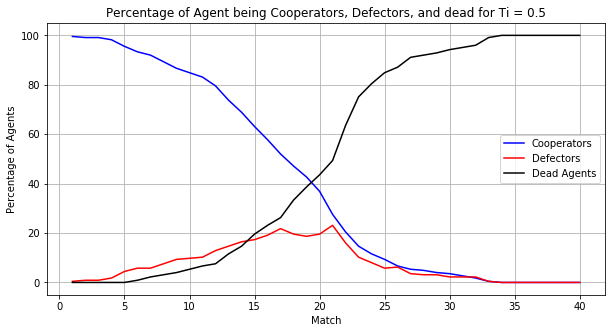

In [38]:
plt.figure(figsize = (10,5))
plt.plot(statusTable.columns, tallyCoop/n_agent * 100, 
        color = 'b', label = 'Cooperators')
plt.plot(statusTable.columns, tallyDef/n_agent * 100, 
        color = 'r', label = 'Defectors')
plt.plot(statusTable.columns, tallyDead/n_agent * 100, 
        color = 'k', label = 'Dead Agents')
plt.xlabel('Match')
plt.ylabel('Percentage of Agents')
plt.title('Percentage of Agent being Cooperators, Defectors, and dead for Ti = 0.5')
plt.grid()
plt.legend()

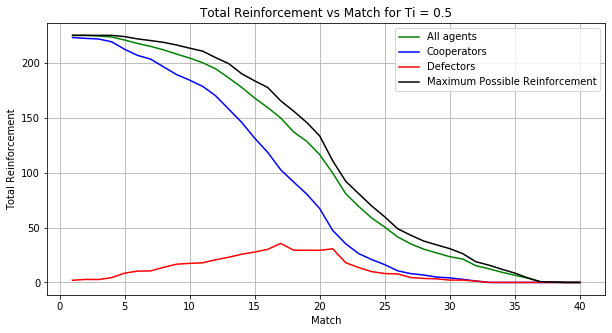

In [39]:
reCoop, reDef = tallyProperty(statusTable, reTable)

plt.figure(figsize = (10,5))
plt.plot(statusTable.columns, reTable.sum(), color = 'g', label = 'All agents')
plt.plot(statusTable.columns, np.array(reCoop), color = 'b', label = 'Cooperators')
plt.plot(statusTable.columns, np.array(reDef), color = 'r', label = 'Defectors')
plt.plot(statusTable.columns, maxReTable.sum(axis = 0), color = 'k', label = 'Maximum Possible Reinforcement')
plt.xlabel('Match')
plt.ylabel('Total Reinforcement')
plt.title('Total Reinforcement vs Match for Ti = 0.5')
plt.grid()
plt.legend()

<ipython-input-47-0bc8fdce0ef2>:6: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(targetTable.columns, targetCoop/tallyCoop, color = 'b', label = 'Cooperators')
<ipython-input-47-0bc8fdce0ef2>:7: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(targetTable.columns, targetDef/tallyDef, color = 'r', label = 'Defectors')


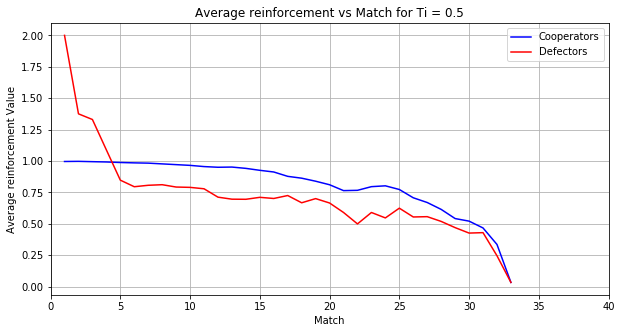

In [47]:
targetTable, prop = reTable, 'reinforcement'
targetCoop, targetDef = tallyProperty(statusTable, targetTable)
fig = plt.figure(figsize = (10,5))
ax = plt.subplot(111)
#ax.plot(targetTable.columns, targetTable.sum()/tallyAlive, color = 'g', label = 'All agent')
ax.plot(targetTable.columns, targetCoop/tallyCoop, color = 'b', label = 'Cooperators')
ax.plot(targetTable.columns, targetDef/tallyDef, color = 'r', label = 'Defectors')
plt.xlabel('Match')
plt.ylabel('Average ' + prop + ' Value')
ax.set_xlim([0, 40])
plt.title('Average ' + prop  + ' vs Match for Ti = 0.5')
plt.grid()
ax.legend()

<ipython-input-37-2c07d2426c84>:36: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(targetTable.columns, (targetCoop/tallyCoop), color = 'b', label = 'Cooperators')
<ipython-input-37-2c07d2426c84>:37: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(targetTable.columns, (targetDef/tallyDef), color = 'r', label = 'Defectors')


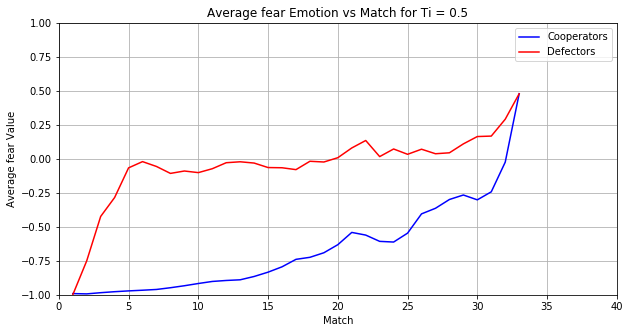

In [41]:
plot_prop(fearTable, 'fear')

<ipython-input-37-2c07d2426c84>:36: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(targetTable.columns, (targetCoop/tallyCoop), color = 'b', label = 'Cooperators')
<ipython-input-37-2c07d2426c84>:37: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(targetTable.columns, (targetDef/tallyDef), color = 'r', label = 'Defectors')


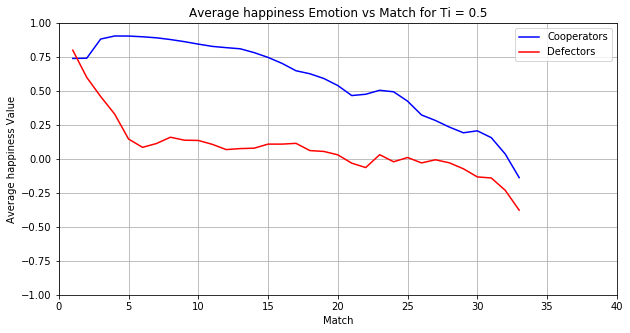

In [42]:
plot_prop(happinessTable, 'happiness')

<ipython-input-37-2c07d2426c84>:36: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(targetTable.columns, (targetCoop/tallyCoop), color = 'b', label = 'Cooperators')
<ipython-input-37-2c07d2426c84>:37: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(targetTable.columns, (targetDef/tallyDef), color = 'r', label = 'Defectors')


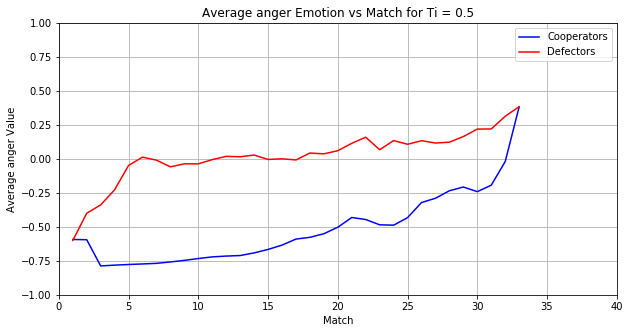

In [43]:
plot_prop(angerTable, 'anger')

<ipython-input-37-2c07d2426c84>:36: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(targetTable.columns, (targetCoop/tallyCoop), color = 'b', label = 'Cooperators')
<ipython-input-37-2c07d2426c84>:37: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(targetTable.columns, (targetDef/tallyDef), color = 'r', label = 'Defectors')


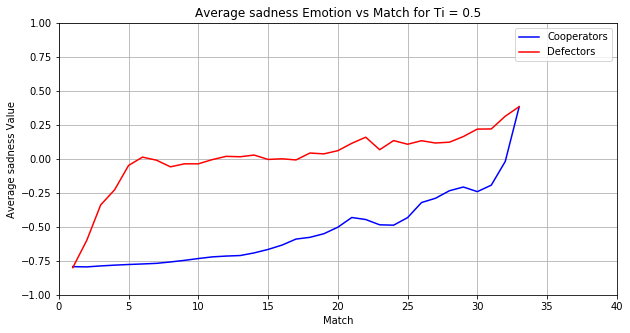

In [44]:
plot_prop(sadnessTable, 'sadness')

<ipython-input-37-2c07d2426c84>:36: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(targetTable.columns, (targetCoop/tallyCoop), color = 'b', label = 'Cooperators')
<ipython-input-37-2c07d2426c84>:37: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(targetTable.columns, (targetDef/tallyDef), color = 'r', label = 'Defectors')


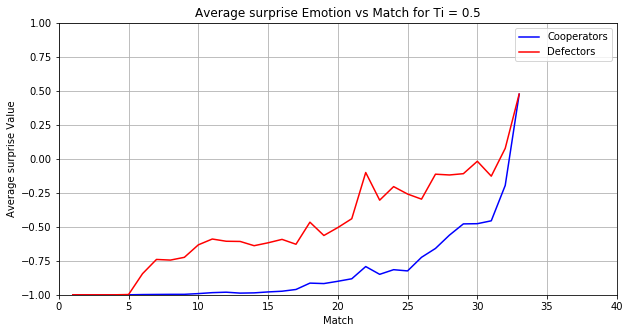

In [45]:
plot_prop(surpriseTable, 'surprise')

<ipython-input-37-2c07d2426c84>:36: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(targetTable.columns, (targetCoop/tallyCoop), color = 'b', label = 'Cooperators')
<ipython-input-37-2c07d2426c84>:37: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(targetTable.columns, (targetDef/tallyDef), color = 'r', label = 'Defectors')


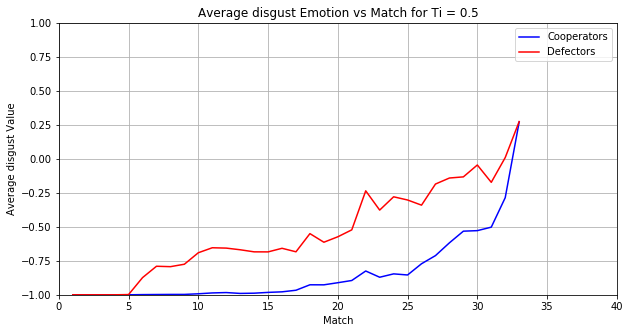

In [46]:
plot_prop(disgustTable, 'disgust')